In [1]:
import torch
import ptychi.api as api
from ptychi.api.task import PtychographyTask
from ptychi.utils import get_default_complex_dtype
import matplotlib.pyplot as plt
import os
import numpy as np
import cupy as cp
import dxchange
import sys


astropy module not found
olefile module not found


In [2]:
# prb_opt = sys.argv[1]=='True'
# pos_opt = sys.argv[2]=='True'
# noise = sys.argv[3]=='True'
# method = sys.argv[4]
# niter = int(sys.argv[5])
# gpu = int(sys.argv[6])

prb_opt = True
pos_opt = True
noise = True
method = 'lsqml'
niter = 100
gpu = 0

torch.cuda.set_device(gpu)
flg = f'{method}_True_{prb_opt}_{pos_opt}_{noise}'


cpag = 5e-3
n = 1024  # object size in each dimension
pad = 0 # pad for the reconstructed probe
npos = 16 # total number of positions
z1 = 4.267e-3 # [m] position of the sample
detector_pixelsize = 3.0e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size

extra = 8
nobj = n+n//8
nprb = n+2*pad
npatch = nprb+2*extra

show = True
path = f'/data/vnikitin/paper/near_field'
path_out = f'/data/vnikitin/paper/near_field/rec0'
print(f'{voxelsize=},{distance=}')


voxelsize=np.float64(1.000078125e-08),distance=0.00425277555546875


In [3]:

def mshow(a, show=True, **args):
    """Plot the 2D array, handling arrays on GPU      

    Parameters
    ----------
    a : (ny, nx) float32
        2D array for visualization
    args : 
        Other parameters for imshow    
    """
    if not show:
        return

    fig, axs = plt.subplots(1, 1, figsize=(3, 3))
    im = axs.imshow(a, cmap='gray', **args)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()
def mshow_complex(a, show=True, **args):
    """Plot the 2D array in the rectangular representation with the real and imag parts, 
    handling arrays on GPU   

    Parameters
    ----------
    a : (ny, nx) complex64
        2D array for visualization
    args : 
        Other parameters for imshow    
    """
    if not show:
        return
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    im = axs[0].imshow(a.real, cmap='gray', **args)
    axs[0].set_title('real')
    fig.colorbar(im, fraction=0.046, pad=0.04)
    im = axs[1].imshow(a.imag, cmap='gray', **args)
    axs[1].set_title('imag')
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()
def mshow_polar(a, show=False, **args):
    """Plot the 2D array in the polar representation with the absolute value and phase,
    handling arrays on GPU       

    Parameters
    ----------
    a : (ny, nx) complex64
        2D array for visualization
    args : 
        Other parameters for imshow    
    """
    if not show:
        return
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    im = axs[0].imshow(np.abs(a), cmap='gray', **args)
    axs[0].set_title('abs')
    fig.colorbar(im, fraction=0.046, pad=0.04)
    im = axs[1].imshow(np.angle(a), cmap='gray', **args)
    axs[1].set_title('phase')
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()

In [4]:
shifts = np.load(f'{path}/data/gen_shifts.npy')[:npos]
shifts_random = np.load(f'{path}/data/gen_shifts_random.npy')[:npos]
prb = np.load(f'{path}/data/gen_prb.npy')
if noise:
    data = np.load(f'{path}/data/ndata.npy')[:npos]
else:
    data = np.load(f'{path}/data/data.npy')[:npos]
ref = np.load(f'{path}/data/ref.npy')
psi = np.load(f'{path}/data/psi.npy')

In [5]:
def multiPaganin(data, wavelength, voxelsize, delta_beta,  alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    numerator = 0
    denominator = 0
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2+fy**2)
    numerator = numerator + taylorExp * (rad_freq)
    denominator = denominator + taylorExp**2
    denominator = denominator + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = (delta_beta) * 0.5 * phase
    return phase

def rec_init(rdata,ishifts):
    recMultiPaganin = cp.zeros([nobj,nobj],dtype='float32')
    recMultiPaganinr = cp.zeros([nobj,nobj],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = rdata[j]        
        rr = r*0+1 # to compensate for overlap
                
        rpsi = cp.ones([nobj,nobj],dtype='float32')
        rrpsi = cp.ones([nobj,nobj],dtype='float32')
        stx = nobj//2-ishifts[j,1]-n//2
        endx = stx+n
        sty = nobj//2-ishifts[j,0]-n//2
        endy = sty+n
        rpsi[sty:endy,stx:endx] = r
        rrpsi[sty:endy,stx:endx] = rr

        rpsi = multiPaganin(rpsi, wavelength, voxelsize,  24.05, cpag)
        
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi
        
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1    
    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

ishifts = np.round(shifts).astype('int32')

rdata = cp.array(data/(ref+1e-5))
rec_paganin = rec_init(rdata,ishifts).get()
# mshow_polar(rec_paganin,show)


  0%|          | 0/100 [00:00<?, ?it/s]/home/beams/TOMO/conda/miniforge3/envs/ptychi/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1733146582594/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


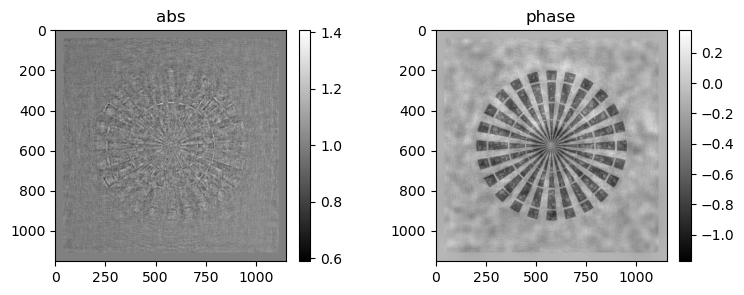

In [6]:
if method == 'lsqml':
    obj_opt = True

    if pos_opt:
        positions_px = -shifts_random
    else:
        positions_px = -shifts
    if prb_opt:
        probe = 1+0*torch.from_numpy(prb[np.newaxis,np.newaxis])            
    else:
        probe = torch.from_numpy(prb[np.newaxis,np.newaxis])
        
    if prb_opt==False and pos_opt==False:
        step= 2
    else:
        step=1.5#if error in shifts are big 1.3

    options = api.LSQMLOptions()
    options.data_options.data = np.fft.fftshift(data,axes=(-2,-1))

    options.object_options.initial_guess = torch.ones([1, nobj,nobj], dtype=get_default_complex_dtype())
    options.object_options.pixel_size_m = voxelsize
    options.object_options.optimizable = obj_opt
    options.object_options.optimizer = api.Optimizers.SGD
    options.object_options.step_size = step

    options.probe_options.initial_guess = probe
    options.probe_options.optimizable = prb_opt
    options.probe_options.optimizer = api.Optimizers.SGD
    options.probe_options.step_size = step

    options.probe_position_options.position_x_px = positions_px[:, 1]
    options.probe_position_options.position_y_px = positions_px[:, 0]
    options.probe_position_options.optimizable = pos_opt

    options.reconstructor_options.batch_size = 16
    options.reconstructor_options.noise_model = api.NoiseModels.GAUSSIAN
    options.reconstructor_options.num_epochs = niter

    options.reconstructor_options.csv = flg 

    options.object_options.initial_guess = torch.from_numpy(rec_paganin[np.newaxis])#rec_paganin[np.newaxis])
    # options.object_options.initial_guess = torch.from_numpy(psi[np.newaxis])#rec_paganin[np.newaxis])
    task = PtychographyTask(options)

    task.run()

    recon = task.get_data_to_cpu('object', as_numpy=True)[0]
    rec_prb = task.get_data_to_cpu('probe', as_numpy=True)[0]

    mshow_polar(recon,mshow)
    # mshow_polar(rec_prb[0],mshow)

    # os.system(f"cp lsqml lsqml_{flg}")
    dxchange.write_tiff(np.abs(recon),f'{path_out}_{flg}/crec_psi_abs/0',overwrite=True)
    dxchange.write_tiff(np.angle(recon),f'{path_out}_{flg}/crec_psi_angle/0',overwrite=True)
    dxchange.write_tiff(np.abs(rec_prb[0]),f'{path_out}_{flg}/crec_prb_abs/0',overwrite=True)
    dxchange.write_tiff(np.angle(rec_prb[0]),f'{path_out}_{flg}/crec_prb_angle/0',overwrite=True)

In [ ]:
if method == 'epie':
    obj_opt = True

    if pos_opt:
        positions_px = -shifts_random
    else:
        positions_px = -shifts
    if prb_opt:
        probe = 1+0*torch.from_numpy(prb[np.newaxis,np.newaxis])
    else:
        probe = torch.from_numpy(prb[np.newaxis,np.newaxis])
    
    if prb_opt==False and pos_opt==False:
        step=0.3
    else:
        step=0.15

    options = api.EPIEOptions()
        
    options.data_options.data = np.fft.fftshift(data,axes=(-2,-1))

    options.object_options.initial_guess = torch.ones([1, nobj,nobj], dtype=get_default_complex_dtype())
    options.object_options.pixel_size_m = voxelsize
    options.object_options.optimizable = obj_opt
    options.object_options.optimizer = api.Optimizers.SGD
    options.object_options.step_size = step
    options.object_options.alpha = 1

    options.probe_options.initial_guess = probe
    options.probe_options.optimizable = prb_opt
    options.probe_options.optimizer = api.Optimizers.SGD
    options.probe_options.step_size = step
    options.probe_options.alpha = 1

    options.probe_position_options.position_x_px = positions_px[:, 1]
    options.probe_position_options.position_y_px = positions_px[:, 0]
    options.probe_position_options.optimizable = pos_opt

    options.reconstructor_options.batch_size = 16
    options.reconstructor_options.num_epochs = 1

    options.reconstructor_options.csv = flg

    options.object_options.initial_guess = torch.from_numpy(rec_paganin[np.newaxis])
    # options.object_options.initial_guess = torch.from_numpy(psi[np.newaxis])
    task = PtychographyTask(options)
    task.run()
    
    recon = task.get_data_to_cpu('object', as_numpy=True)[0]
    rec_prb = task.get_data_to_cpu('probe', as_numpy=True)[0]
    rec_pos = -task.get_data_to_cpu('probe_positions', as_numpy=True)#[0]
    print(rec_pos)
    dxchange.write_tiff(np.abs(recon),f'{path_out}_{flg}/crec_psi_abs/0',overwrite=True)
    dxchange.write_tiff(np.angle(recon),f'{path_out}_{flg}/crec_psi_angle/0',overwrite=True)
    dxchange.write_tiff(np.abs(rec_prb[0]),f'{path_out}_{flg}/crec_prb_abs/0',overwrite=True)
    dxchange.write_tiff(np.angle(rec_prb[0]),f'{path_out}_{flg}/crec_prb_angle/0',overwrite=True)
    np.save(f'{path_out}_{flg}/crec_shift_0',rec_pos)

: 